# Example - REINFORCE with NonIsotropic Noise

The REINFORCE class of algorithms are slightlt different than BPTT and RFLO. What we care about in this implementation is the idea that the update rule is essentially a scalar reward value that is projected onto pre- and post-synaptic activity.

$$ \Delta W_{ij} \propto \eta (R-\overline{R}) \xi_i h_j$$

Where R is the current reward, $\overline{R}$ is the average reward baseline, $\xi_i$ is the noise injected at the hidden/recurrent layer, and $h_j$ is the presynaptic activity. Various forms of this rule can be used.

$$ \Delta W_{ij} \propto \eta (R-\overline{R}) \sum_t \xi_i(t) h_j(t)$$

where the update is summed over time. We could also have

$$ \Delta W_{ij} \propto \eta (R-\overline{R}) \sum_t \big[ \xi(t) \phi'(u(t)) \big]_i h_j(t)$$

where the derivative of the RNN nonlinearity is taken into account. Finally, we can take into account the influence of local activity at previous timesteps

$$ \Delta W_{ij} \propto \eta (R-\overline{R}) \sum_t \overline{ \big[ \xi(t) \phi'(u(t)) \big]_i h_j(t)}$$

where the low pass filtered form, or elegibility trace, has been included. This is the form that is used in the `reinforce` module below. Note that reward can be injected at every time step, or episodically at the end of a trial

-------

One possible variation on the above weight update algorithm is to _relax the assumption of high-rank, Gaussian noise_ $\xi$. This idea is explored in feedforward linear networks in **Beyond gradients: Noise correlations control Hebbian plasticity to shape credit assignment** (Scott, Frank bioRxiv 2021). In this paper, they focus on two possibilities:

1. Low-rank, isotropic Gaussian noise. They write that if the low-D noise is "isotropic in the subspace it spans ... it implements gradient descent in the subspace of the network weights"
2. Full-rank, non-isotropic Gaussian noise. They write that in this case, "non-isotropic noise interpolates between sampling within a subspace and full-rank sampling, and is graded according to the eigenvalues of the noise covariance"

Below we focus on the low-rank, isotropic Gaussian noise:

1. One way to achieve low-D noise is to generate noise samples in dimension $M$, and then project this noise to a higher dimension $N$
2. Another way to achieve low-D noise is to generate noise samples in dimension $M$, and then only "inject" this noise to a subset of all the recurrent units

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d


# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..") # necessary given folder structure

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE

from utils.plotting import plot_trained_trajectories

In `rnn.py`, recurrent noise is injected in the following manner:

```
self.u = np.dot(self.w_rec, self.h) + np.dot(self.w_in, x_in + self.sig_in*self.rng.randn(self.n_in,1))

self.xi = self.sig_rec*self.rng.randn(self.n_rec,1)
self.h = self.h + (-self.h + self.f(self.u) + self.xi)/self.tau_rec
```

In [3]:
dim_m = 5
dim_n = 10
v = np.random.randn(dim_m)
P = np.zeros((dim_n,dim_m))

# for each row, randomly insert 1
for p in P:
    ind = np.random.choice(np.arange(dim_m,dtype=int),1)
    p[ind] = 1

print('\nprojection matrix P:\n\n',P)

v_ = P@v
print('\nvector v:\n\n', v)
print('\nfull vector v_:\n\n',v_)


projection matrix P:

 [[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]

vector v:

 [ 1.20945645  0.40529401 -0.08616518  0.48048241  0.73857473]

full vector v_:

 [ 0.40529401  0.40529401  1.20945645  1.20945645  0.40529401 -0.08616518
 -0.08616518  1.20945645 -0.08616518  0.73857473]


We can therefore modify this such that $\xi$ can be generated from low-D noise:

```
self.u = np.dot(self.w_rec, self.h) + np.dot(self.w_in, x_in + self.sig_in*self.rng.randn(self.n_in,1))

self.xi = self._generate_recurrent_noise()

self.h = self.h + (-self.h + self.f(self.u) + self.xi)/self.tau_rec
```

Where the function is defined as:

```
def _generate_recurrent_noise(self):

    """ Generate Recurrent Noise
    
    This function generates noise that is injected into the recurrent units.
    Noise is sampled from a gaussian distribution, and can be low-D.
    
    Returns:
    xi: vector of dimension n_rec
    """

    
    v = self.rng.randn(sig_rec_dim,1) # noise vector vector
    
    assert self.sig_rec_dim <= self.n_rec, 'recurrent noise dimension must be less than or equal to number of recurrent units'

    if sig_rec_dim < n_rec:
    

        xi = self.sig_rec * self.noise_projection_matrix @ v

    else:
    
        xi = self.sig_rec * v
        
    return xi
```

and the noise_projection_matrix is defined at initialization

```
assert self.sig_rec_dim <= self.n_rec, 'recurrent noise dimension must be less than or equal to number of recurrent units'
        
# generate projection matrix for low-D noise
if self.sig_rec_dim <= self.n_rec:
     """ project on to all units with matrix P """
    P = np.zeros((self.n_rec,self.sig_rec_dim)) 

    # for each row, randomly insert 1
    for p in P:
        ind = self.rng.choice(np.arange(self.sig_rec_dim,dtype=int),1)
        p[ind] = 1

    self.noise_projection_matrix = P
```


### Initialize Vanilla RNN

The `RNNparams` object stores the parameters, and is passed to the RNN

Note that we do not have any driving feedback

### Create an example Task

Here the task is simply to reach the target at (1,1) given a pulse of trial 20 steps that lasts for 50% of the trial duration (i.e. 10 steps)

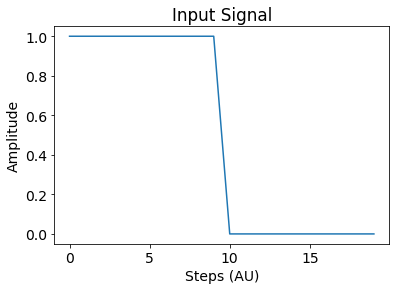

trial duration = 20


In [4]:
trial_duration = 20
n_in=1
frac_on = 0.5
y_target_x = np.expand_dims(np.concatenate((np.zeros(int(trial_duration*frac_on)),np.linspace(0,1,int(trial_duration*(1-frac_on))))),axis=1)
y_target_y = np.expand_dims(np.concatenate((np.zeros(int(trial_duration*frac_on)),np.linspace(0,1,int(trial_duration*(1-frac_on))))),axis=1)
y_teaching_signal = np.concatenate((y_target_x,y_target_y),axis=1)

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1

plt.plot(x_pulse1)
plt.title('Input Signal')
plt.xlabel('Steps (AU)')
plt.ylabel('Amplitude')
plt.show()

task = Task(x_in=x_pulse1,y_target=np.asarray([1,1]))
print('trial duration =',task.trial_duration)

# 1. Train an RNN on a single target using REINFORCE

Note here that we are only learning the recurrent weights `w_rec` for a single target. We loop over different dimensions of recurrent noise.

100%|██████████| 501/501 [00:00<00:00, 540.90it/s]


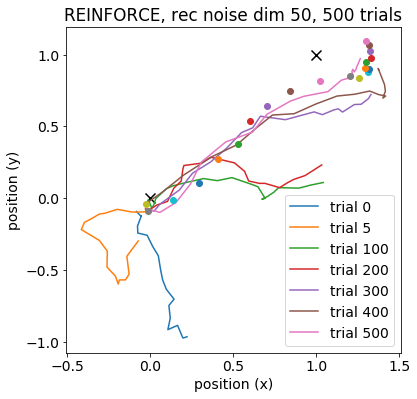

100%|██████████| 501/501 [00:00<00:00, 533.73it/s]


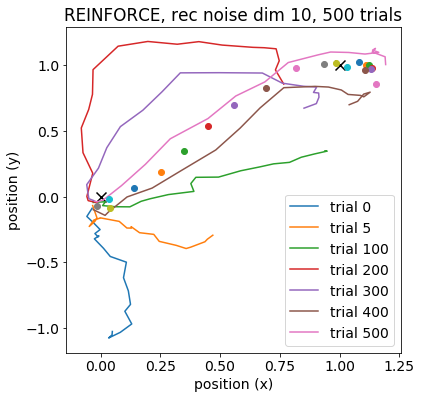

100%|██████████| 501/501 [00:00<00:00, 566.19it/s]


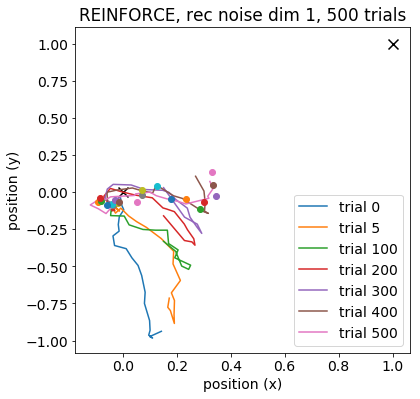

In [5]:

for sig_rec_dim in [50,10,1]:
    # Set RNN Parameters
    params = RNNparams(n_in=1,n_rec=50,n_out=2,tau_rec=5,
                   eta_in=0.1,eta_rec=0.5,eta_out=0.1,
                   sig_in=0.01,sig_rec=0.1,sig_out=0.01,
                   velocity_transform=False,sig_rec_dim=sig_rec_dim,
                   rng=np.random.RandomState(0))

    # Initialize RNN
    net = RNN(params)

    task = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]),y_teaching_signal=y_teaching_signal)

    # initialize simulation
    sim = Simulation(net)

    """ Instantiate learning algorithm """
    # Specify particular matrix/unit to apply algorithm
    reinforce = REINFORCE(net,apply_to=['w_rec'],online=False,tau_reward=5) 

    plt.figure(figsize=(6,6))

    for i in tqdm(range(501)):

        sim.run_trial(task,learn_alg=[reinforce],probe_types=['h','y_out','pos'],train=True)

        if i % 100 == 0 or i == 5:
            plt.plot(sim.probes['pos'].squeeze()[:,0],sim.probes['pos'].squeeze()[:,1],label='trial {}'.format(i))

    sim.run_trial(task,probe_types=['h','pos'],train=False)


    plt.plot([sim.probes['pos'].squeeze()[:,0]],[sim.probes['pos'].squeeze()[:,1]],'o')
    plt.title('REINFORCE, rec noise dim {}, {} trials'.format(sig_rec_dim,i))
    plt.scatter(task.y_target[0,:],task.y_target[1,:],s=100,marker='x',color='k')
    plt.scatter(0,0,s=100,marker='x',color='k')
    # plt.xlim(-1.5,1.5)
    # plt.ylim(-1.5,1.5)
    plt.xlabel('position (x)')
    plt.ylabel('position (y)')
    plt.legend()
    plt.show()

# 2. Train RNN on four targets using REINFORCE, offline

In [6]:
trial_duration = 20
n_in=4
frac_on = 0.4

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
# changing input can help...a bit
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = -1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

5000it [00:08, 575.83it/s]
5000it [00:08, 590.44it/s]
5000it [00:08, 582.25it/s]


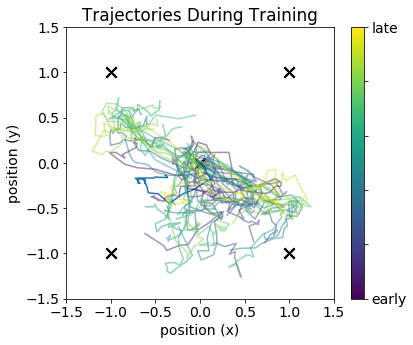

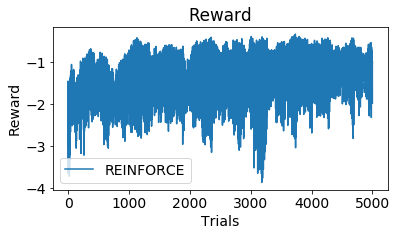

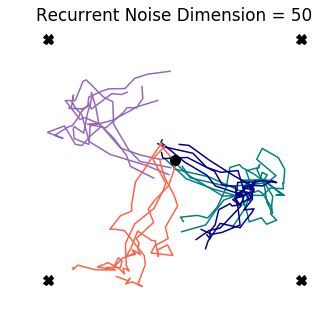

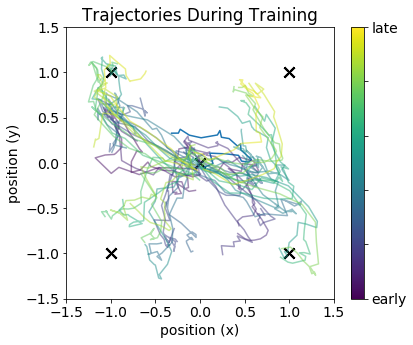

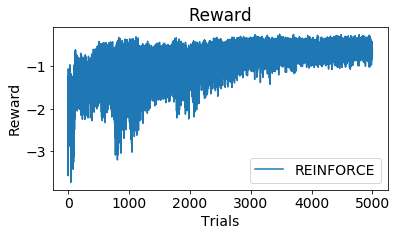

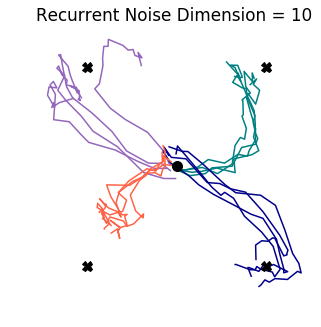

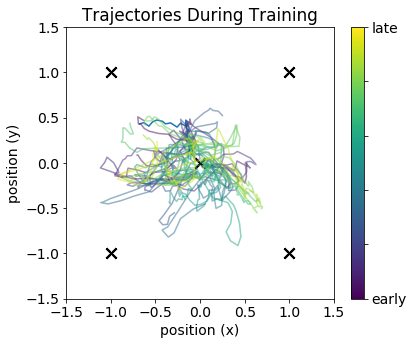

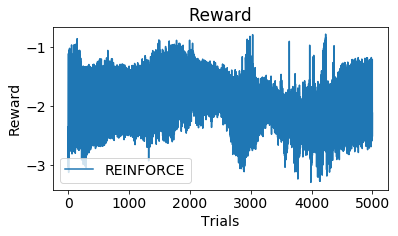

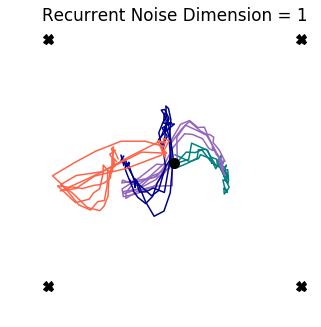

In [7]:
# Loop over dimension of recurrent noise
for sig_rec_dim in [50,10,1]:
    params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
                   eta_in=0.1,eta_rec=0.25,eta_out=0.1,
                   sig_in=0.01,sig_rec=0.25,sig_out=0.01,
                   velocity_transform=False,sig_rec_dim=sig_rec_dim,
                   rng=np.random.RandomState(1))

    # Initialize RNN
    net = RNN(params)

    # initialize simulation
    sim = Simulation(net)

    # instantiate learning algorithm
    # and specify particular matrix/unit to apply algorithm
    reinforce = REINFORCE(net,apply_to=['w_rec'],online=False,tau_reward=5) 
    sim.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['pos','reward'], plot=True, plot_freq=100)
    
    fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='Recurrent Noise Dimension = {}'.format(sig_rec_dim))

# 3. REINFORCE with large number of units but low-D noise
#### REINFORCE also seems to do poorly with a large number of recurrent units. Can low-D noise help?

5000it [00:37, 132.41it/s]
5000it [00:37, 132.98it/s]
5000it [00:35, 139.86it/s]
5000it [00:45, 108.89it/s]


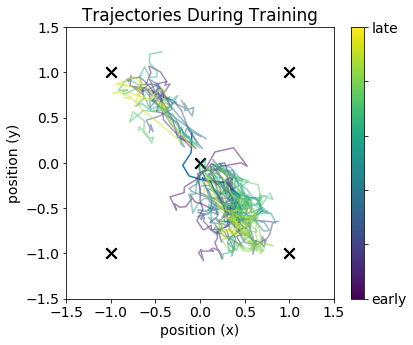

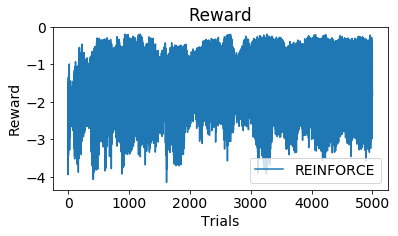

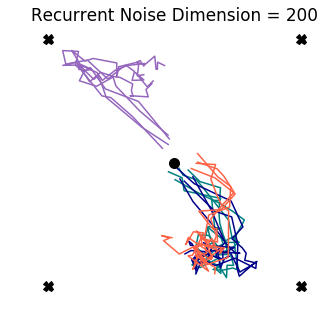

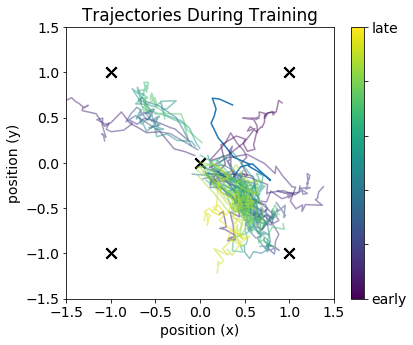

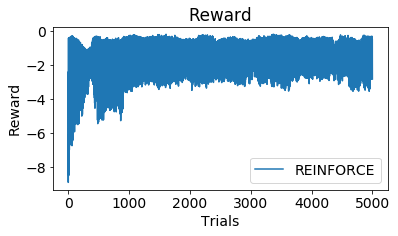

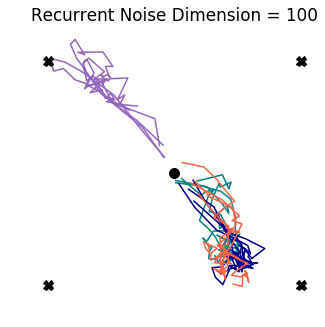

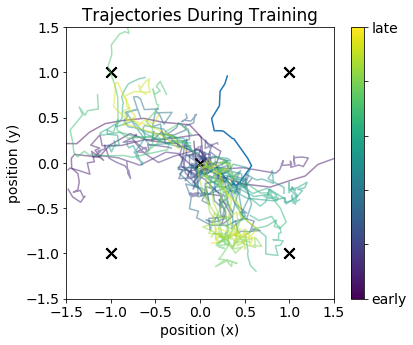

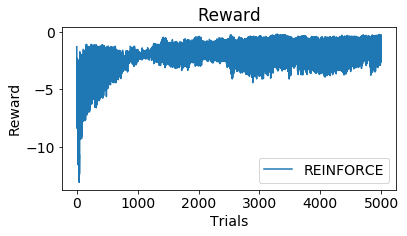

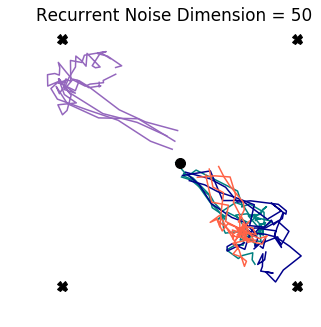

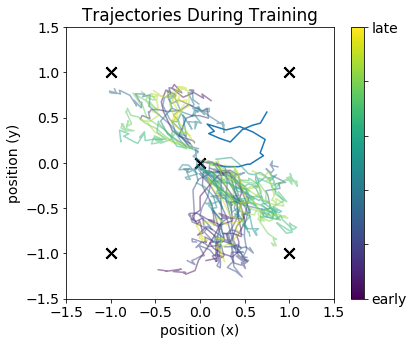

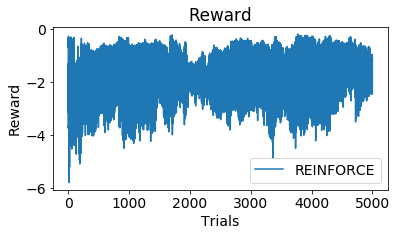

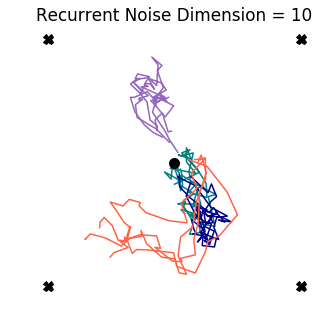

In [8]:
# Loop over dimension of recurrent noise
for sig_rec_dim in [200,100,50,10]:
    params = RNNparams(n_in=4,n_rec=200,n_out=2,tau_rec=5,
                   eta_in=0.1,eta_rec=0.25,eta_out=0.1,
                   sig_in=0.01,sig_rec=0.25,sig_out=0.01,
                   velocity_transform=False,sig_rec_dim=sig_rec_dim,
                   rng=np.random.RandomState(1))

    # Initialize RNN
    net = RNN(params)

    # initialize simulation
    sim = Simulation(net)

    # instantiate learning algorithm
    # and specify particular matrix/unit to apply algorithm
    reinforce = REINFORCE(net,apply_to=['w_rec'],online=False,tau_reward=5) 
    sim.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['pos','reward'], plot=True, plot_freq=100)
    
    fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='Recurrent Noise Dimension = {}'.format(sig_rec_dim))

In [21]:
params.print_params()

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.01
sig_rec: 0.25
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.25
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
sig_rec_dim: 10
rng: <mtrand.RandomState object at 0x7fd469d9cee8>


# 4. Train REINFORCE, 4 Targets, velocity transform

Note that the RNN parameters are slightly different here

In [ ]:
seed=5
fig1, ax1 = plt.subplots(1,1)
# Loop over dimension of recurrent noise
for sig_rec_dim in [75,50,25,10]:
    # Set RNN Parameters
    params = RNNparams(n_in=4,n_rec=75,n_out=2,tau_rec=5,
                   eta_in=0.1,eta_rec=0.1,eta_out=0.1,
                   sig_in=0.01,sig_rec=0.5,sig_out=0.01,
                   velocity_transform=True, tau_vel = 2, dt_vel = 0.1,sig_rec_dim=sig_rec_dim,
                   rng=np.random.RandomState(seed))

    # Initialize RNN
    net = RNN(params)


    # initialize simulation
    sim = Simulation(net)

    # instantiate learning algorithm
    # Specify particular matrix/unit to apply algorithm
    reinforce = REINFORCE(net,apply_to=['w_rec'],online=False,tau_reward=5) 

    sim.run_session(n_trials=25000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['pos','reward'], plot=True, plot_freq=100)

    fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='Recurrent Noise Dimension = {}'.format(sig_rec_dim))


    """ Plot Loss with moving average for comparison across sweep """
    av = uniform_filter1d(np.mean(sim.session_probes['reward'],axis=1),50)
    ax1.plot(av,label='sig_rec_dim={}'.format(sig_rec_dim))

ax1.set_xlabel('trials')
ax1.set_ylabel('reward')
ax1.set_title('seed {}'.format(seed))
ax1.legend(loc=4)
plt.show()


25000it [01:11, 349.83it/s]
823it [00:02, 386.39it/s]

In [54]:
params.print_params()

n_in: 4
n_rec: 75
n_out: 2
sig_in: 0.01
sig_rec: 0.5
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 2
dt_vel: 0.1
sig_rec_dim: 10
rng: <mtrand.RandomState object at 0x7f9f9a187ea0>


15000it [00:55, 269.47it/s]


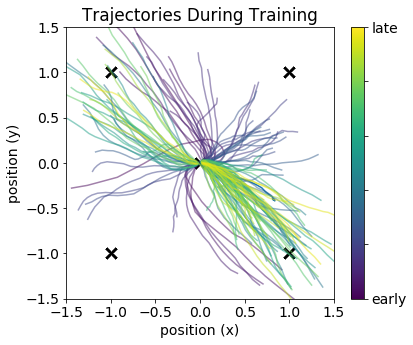

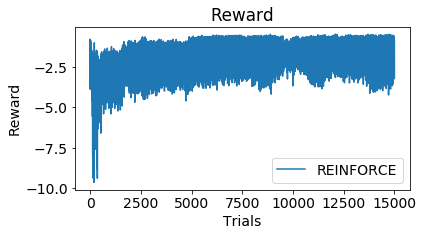

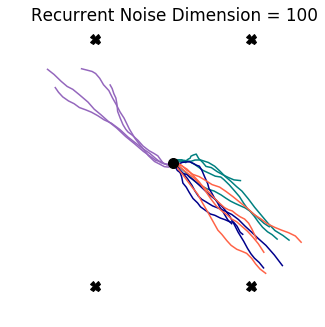

In [42]:
sig_rec_dim = 100

# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=100,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.01,sig_rec=0.5,sig_out=0.01,
               velocity_transform=True, tau_vel = 1, dt_vel = 0.1,sig_rec_dim=sig_rec_dim,
               rng=np.random.RandomState(0))

# Initialize RNN
net = RNN(params)

# """ set noise projection matrix """
#net.noise_projection_matrix = np.expand_dims(np.copy(net.w_out)[0,:],1) * np.copy(net.noise_projection_matrix) + np.expand_dims(np.copy(net.w_out)[1,:],1) * np.copy(net.noise_projection_matrix)# element wise multiplication


# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
reinforce = REINFORCE(net,apply_to=['w_rec'],online=False,tau_reward=5) 

sim.run_session(n_trials=15000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['pos','reward'], plot=True, plot_freq=100)

fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='Recurrent Noise Dimension = {}'.format(sig_rec_dim))


In [39]:
params.print_params()

n_in: 4
n_rec: 100
n_out: 2
sig_in: 0.01
sig_rec: 0.5
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 1
dt_vel: 0.1
sig_rec_dim: 25
rng: <mtrand.RandomState object at 0x7f9faeb51a20>
